In [125]:
import pandas as pd

In [126]:
import plotly.express as px 

In [127]:
pip install matplotlib seaborn

/Users/arijuljulian/.zshenv:source:1: no such file or directory: /Users/arijuljulian/.cargo/env
Note: you may need to restart the kernel to use updated packages.


In [124]:
import matplotlib.pyplot as plt

In [25]:
import seaborn as sns

In [26]:
from understatapi import UnderstatClient

In [27]:
understat = UnderstatClient()

In [28]:
# Premier League player data for 2022 season
pl_player_2022 = understat.league(league="EPL").get_player_data(season="2022")
pl_22 = pd.DataFrame(pl_player_2022)

In [29]:
# Premier League player data for 2023 season
pl_player_2023 = understat.league(league="EPL").get_player_data(season="2023")

In [30]:
# Helper function: gets season data for team inputted during select season
def get_team_data(team_name, year):

    with UnderstatClient() as understat:
        team_match_data = understat.team(team=team_name).get_match_data(season=year)
    
    return pd.DataFrame(team_match_data)

In [31]:
# Get data for every player playing in the Premier League in 2019/20
league_player_data = understat.league(league="EPL").get_player_data(season="2019")

# Get the name and id of one of the players
player_id, player_name = league_player_data[0]["id"], league_player_data[0]["player_name"]

# Get data for every shot this player has taken in a league match (for all seasons)
player_shot_data = understat.player(player=player_id).get_shot_data()

In [32]:
# Get data for every league match involving Manchester United in 2019/20
team_match_data = understat.team(team="Manchester_United").get_match_data(season="2019")

# Get the id for the first match of the season
match_id = team_match_data[0]["id"]

# Get the rosters for the both teams in that match
roster_data = understat.match(match=match_id).get_roster_data()

In [33]:
pl_player_df = pd.DataFrame(pl_player_2023)

# Data Cleaning

In [34]:
# Converting specific columns to numeric
cols_to_convert = ['xG', 'xA', 'npxG', 'xGChain', 'xGBuildup']

for col in cols_to_convert:
    pl_player_df[col] = pd.to_numeric(pl_player_df[col], errors='coerce')

In [35]:
# Rounding below columns to two decimal columns
cols_to_round = ['xG', 'xA', 'npxG', 'xGChain', 'xGBuildup']

for col in cols_to_round:
    pl_player_df[col] = pl_player_df[col].round(2)

# Shot Data Visualizations

In [36]:
saka_id = pl_player_df[pl_player_df['player_name'] == 'Bukayo Saka'].iloc[0]['id']
saka_id

'7322'

In [37]:
pl_player_df

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,6049,Solly March,2,165,3,2.02,0,0.11,8,3,0,0,M,Brighton,3,2.02,2.44,0.39
1,6552,Bryan Mbeumo,2,180,3,2.97,0,0.09,6,1,0,0,F,Brentford,1,1.45,1.45,0.00
2,5232,Alexander Isak,2,148,2,1.16,0,0.00,3,0,0,0,F,Newcastle United,2,1.16,1.17,0.53
3,5786,Yoane Wissa,2,164,2,1.21,0,0.07,10,2,0,0,F,Brentford,2,1.21,0.76,0.00
4,7814,Taiwo Awoniyi,2,99,2,1.06,0,0.08,2,2,0,0,F S,Nottingham Forest,2,1.06,1.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,11730,Anis Ben Slimane,1,9,0,0.00,0,0.00,0,0,1,0,S,Sheffield United,0,0.00,0.00,0.00
338,11731,Andre Brooks,2,16,0,0.00,0,0.00,0,0,0,0,S,Sheffield United,0,0.00,0.00,0.00
339,11807,Ian Maatsen,1,2,0,0.00,0,0.00,0,0,0,0,S,Chelsea,0,0.00,0.00,0.00
340,11810,Mason Burstow,1,1,0,0.00,0,0.00,0,0,0,0,S,Chelsea,0,0.00,0.00,0.00


In [38]:
saka_shot_data = pd.DataFrame(understat.player(player=saka_id).get_shot_data())

In [43]:
# Draws football pitch

def draw_pitch():
    # Setup the field
    fig, ax = plt.subplots(figsize=(10,7))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Draw the field boundary
    plt.plot([0, 0, 1, 1, 0], [0, 1, 1, 0, 0], color="green")
    
    # Goal boxes (can add more details like penalty spots, half-line, etc.)
    plt.plot([0, 0.2, 0.2, 0], [0.22, 0.22, 0.78, 0.78], color="green")
    plt.plot([1, 0.8, 0.8, 1], [0.22, 0.22, 0.78, 0.78], color="green")
    
    return fig, ax

In [110]:
# Function to draw shot map from the given DataFrame

def draw_shot_map(df):
    fig, ax = draw_pitch()

    # Adjusting the coordinates
    df['X'] = 1 - df['X'].astype(float)
    df['Y'] = 1 - df['Y'].astype(float)
    
    shot_palette = {'Goal': 'green', 'MissedShots': 'red', 'SavedShot': 'red',
                    'BlockedShot': 'red', 'ShotOnPost': 'blue', 'OwnGoal': 'red'}
    
    sns.scatterplot(data=df, x='X', y='Y', hue='result', size='xG', sizes=(5, 100), palette=shot_palette, ax=ax)
    plt.title("Shot Map")

    # Adjusting the legend
    leg = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})
    for lh in leg.legend_handles:
        lh.set_alpha(1)  # Ensure the legend markers are not transparent
    
    plt.show()

In [111]:
# Function to fetch data and draw the shot map for a given player ID

def plot_player_shots(player_id):
    with UnderstatClient() as understat:
        shots_data = understat.player(player=player_id).get_shot_data()

     
    df = pd.DataFrame(shots_data)
    df['xG'] = pd.to_numeric(df['xG'], errors='coerce')
    df['xG'] = df['xG'].round(2)
    df = df[['X', 'Y', 'result', 'xG']]
    draw_shot_map(df)

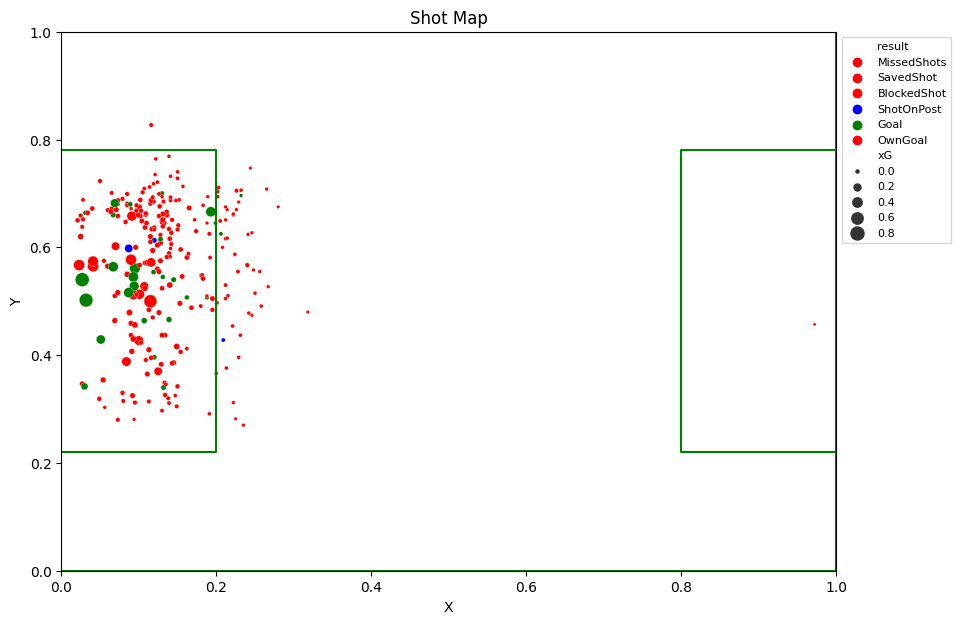

In [113]:
# Example usage with Bukayo Saka

plot_player_shots(saka_id)

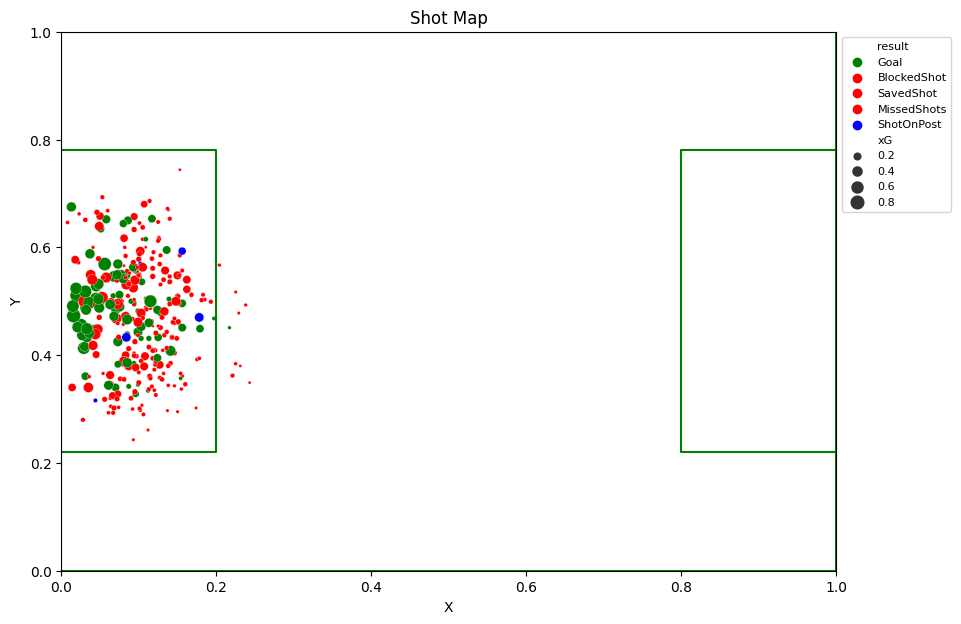

In [117]:
# Example usage with Erling Haaland (tap-in merchant)

haaland_id = pl_player_df[pl_player_df['player_name'] == 'Erling Haaland'].iloc[0]['id']
plot_player_shots(haaland_id)